# Short guide to the extreme-H python implementation.

# Dependencies

In [1]:
# Libraries
import pandas as pd 
import numpy as np
from scipy import stats
from scipy.stats import weibull_min,gamma, gengamma, invgamma,halfnorm,halfgennorm,rayleigh,erlang
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import genextreme
from scipy import integrate
from pynverse import inversefunc
import scipy.stats as stats
from scipy.stats import uniform
from scipy.integrate import quad
from scipy.optimize import root_scalar

/home/tiago/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Auxiliar functions

In [2]:
def H_teta(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def pdf_HG(y, par):
    t1, t2, t3, t4, t5, t6 = par
    H_val = H_teta(t1, t2, t3, t4, t5, t6)
    y = np.array(y)
    pdfh = 1 / H_val * y**t6 * np.exp(-t1 * y - (t2 * y**t3 + t4)**t5)
    return pdfh

def NumIntH(a1, a2, a3, a4, a5, a6):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]

def NumIntH_distribution(a1, a2, a3, a4, a5, a6, y):
    return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, y)[0]

def distribution_extreme_H(x, par):
    t1, t2, t3, t4, t5, t6 = par
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)
    
    for index, val in enumerate(x):
        cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y
    
# cost/loss function
def ecdf_error(params, data):
    x_empirical, y_empirical = ecdf(data)
    y_theoretical = distribution_extreme_H(x_empirical, params)
    error = np.sum((y_empirical - y_theoretical) ** 2)
    return error

In [3]:
#density function
#y: data set
def dg(y, theta1, theta2, theta3, theta4, theta5, theta6):
    # print('DG theta1=', theta1, type(theta1))
    # print('DG y=', y, type(y))
    c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
    return (1./c_theta)*(y**theta6)*np.exp(-theta1*y-((theta2*y**theta3)+theta4)**theta5)

#log-likelihood function
#x0: data set
def llf(x, t1, t2, t3, t4, t5, t6):

    # print('llf pre-filter x=', x)

    x0=x[dg(x, t1, t2, t3, t4, t5, t6)>0]

    # print('llf pos-filter x0=', x0, 'x<=0: ', x[dg(x, t1, t2, t3, t4, t5, t6)<=0])
    return (sum(np.log(dg(x0, t1, t2, t3, t4, t5, t6))))

def minus_llf(params, data):
    t1, t2, t3, t4, t5, t6 = params
    return -1*llf(data, t1, t2, t3, t4, t5, t6)

global global_parGlobal

def eval_fit_extreme(samples, parameters_tuple, no_print=True):
      
    logLik = llf(samples, parameters_tuple[0], parameters_tuple[1], parameters_tuple[2], parameters_tuple[3], parameters_tuple[4], parameters_tuple[5])

    k = len(parameters_tuple)
    aic = 2*k - 2*(logLik)
    n = np.log(len(samples))
    aicc = aic + 2*k*(k+1)/(n-k-1)

    bic = k*n-2*logLik
    edc = -2*logLik-k*np.log(n)

    if(no_print):
        print('AIC: ', aic, 'AICc:', aicc, 'BIC: ', bic, 'EDC:', edc,'Log-Likelihood', logLik)

    global global_parGlobal
    
    global_parGlobal = parameters_tuple

    # print('global_parGlobal', global_parGlobal)
    
    ks = stats.kstest(samples, distribution_extreme_H_ks)

    if(no_print):
        print('KS :', ks)
    
    return aic, aicc, bic, edc, logLik

def distribution_extreme_H_ks(x):
    #print('global_parGlobal', global_parGlobal)
    t1, t2, t3, t4, t5, t6 = global_parGlobal
    c_theta = NumIntH(t1, t2, t3, t4, t5, t6)
   
    cdf_vec = [0.]*len(x)
    
    for index, val in enumerate(x):
        if val==0:
            cdf_vec[index] = 0
        elif np.isnan(val):
            cdf_vec[index] = 0
        else:
            # print('val =', val)
            cdf_vec[index] = (1./c_theta) * NumIntH_distribution(t1, t2, t3, t4, t5, t6, val)

    return cdf_vec


In [4]:
# Generator and PPF

def _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6):
    
    if isinstance(x, float):      
        
        # print(x)
        
        if x==0:
            return 0
            
        c_theta = NumIntH(theta1, theta2, theta3, theta4, theta5, theta6)
        return (1./c_theta)*NumIntH_distribution(theta1, theta2, theta3, theta4, theta5, theta6, x)
    else:
        return distribution_extreme_H(x, [theta1, theta2, theta3, theta4, theta5, theta6])

def inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,target):
    sol = root_scalar(lambda x, *args: _distribution_extreme_H_priv(x, *args) - target,
                      bracket=(0,1000),# coloquei um limite superior alto, mas da pra estimar a partir dos parametros, eventualmente.
                      args=(theta1, theta2, theta3, theta4, theta5, theta6))
    return sol.root

def extreme_H_rvs2(theta_vec, size=1):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]

    y_values = uniform.rvs(loc=0.0001,scale=0.9998,size=size)

    inv_vals = [inversefunc2(theta1, theta2, theta3, theta4, theta5, theta6,y) for y in y_values]

    return np.array(inv_vals)
    
def extreme_H_ppf(samples, theta_vec):
    theta1 = theta_vec[0]
    theta2 = theta_vec[1]
    theta3 = theta_vec[2]
    theta4 = theta_vec[3]
    theta5 = theta_vec[4]
    theta6 = theta_vec[5]
    my_F_distribution = (lambda x: _distribution_extreme_H_priv(x, theta1, theta2, theta3, theta4, theta5, theta6))
    
    y_values = samples
    
    return inversefunc(my_F_distribution, y_values=y_values)

## All-in-one

In [5]:
def estimate_extremeH(samples, particular_model_from_table1=4, initial_guess=[]):

    match particular_model_from_table1:
        case 1:
            print("Frechet")

            base_distribution = stats.invweibull
            
            particular_parameters = base_distribution.fit(samples, floc=0)

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]
        
            sigma = particular_parameters[2]
            shape = particular_parameters[0]
            
            # Frechet: from Table 1
            initial_params = [0, 1/sigma, 1, 0, -shape, -shape-1]
                     
            print('shape =', shape, ' scale=', sigma)
            print('initial guess ', initial_params)

        case 2:
            print("Weibull")
 
            base_distribution = stats.weibull_min

            particular_parameters = base_distribution.fit(samples, floc=0)

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (0, 50)]        
            
            sigma = particular_parameters[2]
            shape = particular_parameters[0]
            
            # Weibull: from Table 1
            initial_params = [0, 1/sigma, 1, 0, shape, shape-1]                     
            
            print('shape =', shape, ' scale=', sigma)
            print('initial guess ', initial_params)
            
        case 3:
            print("Gamma")

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]
        
            shape, loc, scale = gamma.fit(samples, floc=0)  
            
            alpha = shape
            beta =  1 / scale  
            
            initial_params = [beta, 0, 1, 0, 1, shape-1]
            
        case _:  # The wildcard '_' acts as the default case
            print("Half-normal")

            bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]
        
            _, scale = halfnorm.fit(samples, floc=0)    
            
            initial_params = [1, 1/scale**2, 2, 0, 1, 0]

    data = np.array(samples)

    if len(initial_guess) == 0:
        # LSE ECDF vs CDF: Algorithm 1
        result = minimize(ecdf_error, initial_params, args=(data,), bounds=bounds, method='Nelder-Mead')
        optimal_params = result.x
        print("[Algorithm 1] ECDF optimized parameters:", optimal_params)
    else:
        optimal_params = initial_guess
        print("Got a guess from user input:", optimal_params)    
        
    # MLE: Algorithm 2 (using n-tuple from Algorithm 1)
    if particular_model_from_table1 != 3:
        result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='Nelder-Mead')
    else:
        result = minimize(minus_llf, optimal_params, args=(np.asarray(data),), bounds=bounds, method='L-BFGS-B')

    optimal_params_llf = result.x
    
    print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)
        
    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, initial_params)

    aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params_llf)

    return optimal_params_llf, aic, aicc, bic, edc, logLik

# Examples

In [6]:
def plot_pdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = pdf_HG(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('pdf', fontsize=14)
    plt.show()
        
    return

def plot_cdf(parameters_tuple, atitle, xlabel):    
    
    fig, ax = plt.subplots(1, 1)
    
    x=np.arange(1, 100)

    pdf_values = distribution_extreme_H(x, parameters_tuple)

    ax.plot(x, pdf_values, 'r-', lw=5, alpha=0.6)
    ax.set_xlim([x[0], x[-1]])
       
    plt.title(atitle,fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('cdf', fontsize=14)
    plt.show()
        
    return

## Plotting PDF and CDF from a parameter tuple

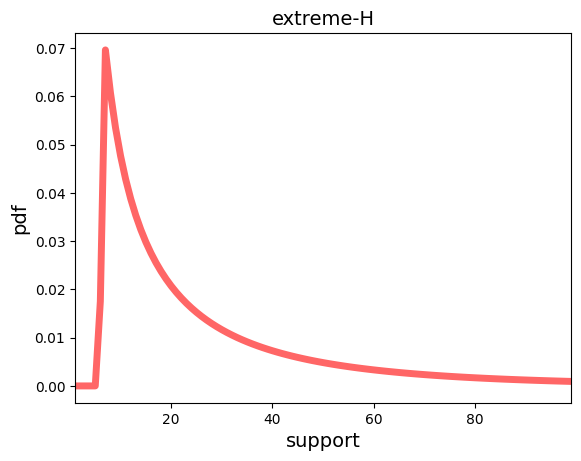

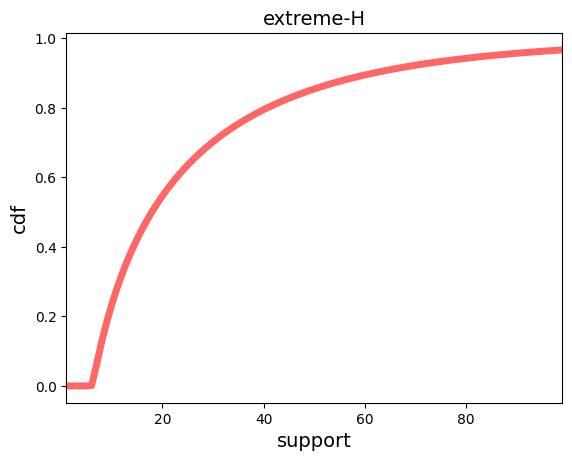

In [7]:
parameter_tuple = [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]

plot_pdf( parameter_tuple, 'extreme-H', 'support')

plot_cdf( parameter_tuple, 'extreme-H', 'support')

## Taking a parameter tuple to generate samples

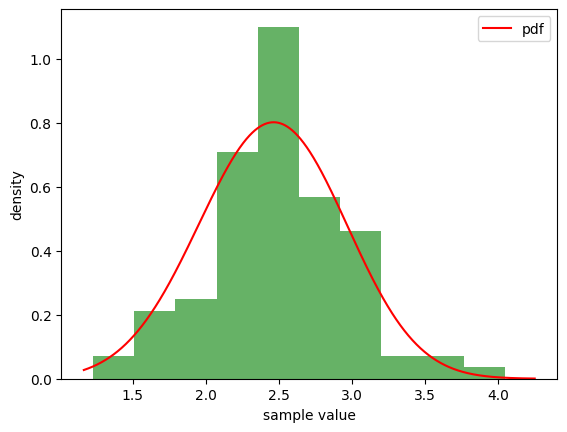

In [8]:
#parameters_tuple = [2.10280344e-02,  7.67695842e-04,  3.97317286e+00,  7.11604099e-03, -9.50968970e+00, -8.99142058e-01]
parameters_tuple = [2.55584476e-05, 6.43480671e-01, 6.27314530e-01, 1.83895256e-02, 5.40854354e+00, 7.15147852e+00]

sample = extreme_H_rvs2(parameters_tuple, 100)

# print(sample)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(0.95*min(sample), 1.05*max(sample), 1000)
pdf_values = pdf_HG(x, parameters_tuple)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

## Trying Algorithms 1 and 2 from a sample.
### Remark: we need a initial guess to start both algorithms.
#### For Algorithm 1, we can take a particular case (from Table 1) that fits data  

In [9]:
X = sample
bounds = [(0, 10), (0, 10), (-10, 10), (0, 10), (-10, 10), (-10, 50)]

# we need an initial guess: it is recommended to come from particular cases (Table 1)
initial_params = [0.2, 0.1, 3, 0.1, -9 , -1]

# LSE ECDF vs CDF: Algorithm 1
result = minimize(ecdf_error, initial_params, args=(X,), bounds=bounds, method='Nelder-Mead')
optimal_params = result.x

print("[Algorithm 1] ECDF optimized parameters:", optimal_params)

# MLE: Algorithm 2 (using n-tuple from Algorithm 1)
result = minimize(minus_llf, optimal_params, args=(np.asarray(X),), bounds=bounds, method='Nelder-Mead')
optimal_params_llf = result.x

print("[Algorithm 2] MLE Optimized Parameters:", optimal_params_llf)

[Algorithm 1] ECDF optimized parameters: [ 1.30646905e+00  6.21475085e-07  1.00000000e+01  0.00000000e+00
 -2.64403084e-01 -9.09509340e+00]
[Algorithm 2] MLE Optimized Parameters: [ 9.46488850e+00  3.33508931e-08  2.89490433e-01  0.00000000e+00
 -3.26533438e-01 -1.34639952e+00]


/tmp/ipykernel_237360/1574089033.py:12: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  return quad(lambda x: (x**a6)*np.exp(-a1*x - (a2*x**a3 + a4)**a5), 0, np.inf)[0]


AIC:  148.51763402222102 AICc: 113.44207269902199 BIC:  164.14865513814956 EDC: 127.35455626737361 Log-Likelihood -68.25881701111051
KS : KstestResult(statistic=0.09013318277942498, pvalue=0.36885694364461163, statistic_location=2.133317906179043, statistic_sign=-1)
AIC:  1370.593088050151 AICc: 1335.517526726952 BIC:  1386.2241091660796 EDC: 1349.4300102953036 Log-Likelihood -679.2965440250755
KS : KstestResult(statistic=0.5920881507763465, pvalue=5.976609724114403e-34, statistic_location=3.169912992573486, statistic_sign=1)
AIC:  179.0539440221289 AICc: 143.97838269892986 BIC:  194.68496513805744 EDC: 157.89086626728147 Log-Likelihood -83.52697201106444
KS : KstestResult(statistic=0.07857226783743032, pvalue=0.541263365313441, statistic_location=1.8764930223935317, statistic_sign=1)
AIC:  149.2250281434546 AICc: 114.14946682025558 BIC:  164.85604925938316 EDC: 128.06195038860722 Log-Likelihood -68.6125140717273
KS : KstestResult(statistic=0.07187544377477206, pvalue=0.653013586262617

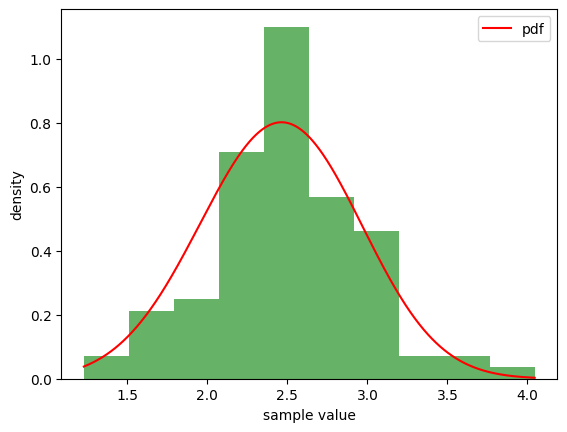

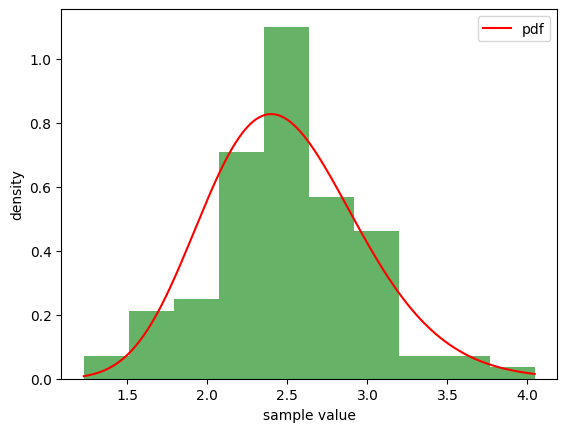

In [10]:
data = sample

generated_params = parameters_tuple

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, generated_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, initial_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params)

aic, aicc, bic, edc, logLik = eval_fit_extreme(data, optimal_params_llf)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, generated_params)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(min(sample), max(sample), 1000)
pdf_values = pdf_HG(x, optimal_params_llf)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

# Table 3 reproduction

## Frechet

In [11]:
# Piracicaba River dataset
# P. L. Ramos, F. Louzada, E. Ramos, and S. Dey. The fréchet distribution: Estimation and application - an overview. Journal of Statistics and Management Systems, 23(3):549–578, 2020
september_flow = [29.19, 8.49, 7.37, 82.93, 44.18, 13.82, 22.28, 28.06, 6.84, 12.14, 153.78, 17.04, 13.47, 15.43, 30.36, 6.91, 22.12, 35.45, 44.66, 95.81, 6.18, 10.00, 58.39, 24.05, 17.03, 38.65, 47.17, 27.99, 11.84, 9.60, 6.72, 13.74, 14.60, 9.65, 10.39, 60.14, 15.51, 14.69, 16.44]


# Frechet
base_distribution = stats.invweibull

X = september_flow
print('X &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(X, 1)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

X & 6.18  &  11.115  &  16.44  &  28.284871794871798  &  32.905  &  153.78  &  39
Frechet
shape = 1.5644948551004678  scale= 13.76067644260458
initial guess  [0, 0.07267084610055136, 1, 0, -1.5644948551004678, -2.5644948551004676]
[Algorithm 1] ECDF optimized parameters: [ 1.30923457e-02  3.63820093e-01  5.16540683e-01  6.02528066e-04
 -5.08883272e+00 -1.44633923e+00]
[Algorithm 2] MLE Optimized Parameters: [ 2.10280344e-02  7.67695842e-04  3.97317286e+00  7.11604099e-03
 -9.50968970e+00 -8.99142058e-01]
AIC:  333.69480197665627 AICc: 308.51825408613166 BIC:  343.67617185343414 EDC: 313.9041871671185 Log-Likelihood -160.84740098832813
KS : KstestResult(statistic=0.07841473668358723, pvalue=0.9548579573017629, statistic_location=27.99, statistic_sign=-1)
AIC:  328.89213306035896 AICc: 303.71558516983436 BIC:  338.87350293713683 EDC: 309.1015182508212 Log-Likelihood -158.44606653017948
KS : KstestResult(statistic=0.08515066054675868, pvalue=0.9171237055863223, statistic_location=17.04, s

## Weibull

In [12]:
# The data represent the strength data measured in GPA, for single carbon fibers. Single fibers were tested under tension at gauge length of 20 mm. 69 samples
# R. Valiollahi, A. Asgharzadeh, and M. Z. Raqab. Estimation of P (Y < X) for Weibull distribution under progressive Type-II censoring. Communications in Statistics-Theory and Methods, 42(24):4476–4498, 2013.
Y_carbon_fiber = [1.312,1.314,1.479,1.552,1.700,1.803,1.861,1.865,1.944,1.958,1.966,1.997,2.006,2.021,2.027,2.055, 2.063,2.098,2.140,2.179,2.224,2.240,2.253,2.270,2.272,2.274,2.301,2.301,2.359,2.382,2.382,2.426, 2.434,2.435,2.478,2.490,2.511,2.514,2.535,2.554,2.566,2.570,2.586,2.629,2.633,2.642,2.648,2.684, 2.697,2.726,2.770,2.773,2.800,2.809,2.818,2.821,2.848,2.880,2.954,3.012,3.067,3.084,3.090,3.096, 3.128,3.233,3.433,3.585,3.585]

base_distribution = stats.weibull_min

Y = Y_carbon_fiber

print('Y &', min(Y),' & ', np.percentile(Y,25), ' & ', np.median(Y), ' & ', np.mean(Y), ' & ', np.percentile(Y,75), ' & ', max(Y), ' & ', len(Y))

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Y, 2)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

Y & 1.312  &  2.098  &  2.478  &  2.4513333333333334  &  2.773  &  3.585  &  69
Weibull
shape = 5.504860090269867  scale= 2.650855606967049
initial guess  [0, 0.37723669194646947, 1, 0, 5.504860090269867, 4.504860090269867]
[Algorithm 1] ECDF optimized parameters: [3.48481435e-04 5.24727602e-01 7.77338095e-01 2.20756525e-03
 5.51341387e+00 6.10516196e+00]
[Algorithm 2] MLE Optimized Parameters: [4.24105804e-04 5.87260964e-01 7.85638476e-01 2.23011647e-03
 4.26882844e+00 7.15291899e+00]
AIC:  111.1922702651877 AICc: 80.82233731599119 BIC:  124.59690929277126 EDC: 90.53323630318033 Log-Likelihood -49.59613513259385
KS : KstestResult(statistic=0.056129327685893515, pvalue=0.9730632666899052, statistic_location=2.821, statistic_sign=1)
AIC:  109.74562582610436 AICc: 79.37569287690785 BIC:  123.15026485368791 EDC: 89.08659186409699 Log-Likelihood -48.87281291305218
KS : KstestResult(statistic=0.04046731320212715, pvalue=0.9996329483052138, statistic_location=2.821, statistic_sign=1)
[4.2410

## Gama

In [13]:
# J. F. Lawless. Statistical models and methods for lifetime data. John Wiley & Sons, 2011.
# W. B. Nelson. Applied Life Data Analysis. John Wiley & Sons, 2005.

Z = [620,470,260,89,388,242, 103,100,39,460,284,1285, 218,393,106,158,152,477, 403,103,69,158,818,947, 399,1274,32,12,134,660, 548,381,203,871,193,531, 317,85,1410,250,41,1101, 32,421,32,343,376,1512, 1792,47,95,76,515,72, 1585,253,6,860,89,1055, 537,101,385,176,11,565, 164,16,1267,352,160,195, 1279,356,751,500,803,560, 151,24,689,1119,1733,2194, 763,555,14,45,776,1, 1747,945,12,1453,14,150, 20,41,35,69,195,89, 1090,1868,294,96,618,44, 142,892,1307,310,230,30, 403,860,23,406,1054,1935, 561,348,130,13,230,250, 317,304,79,1793,536,12, 9,256,201,733,510,660, 122,27,273,1231,182,289, 667,761,1096,43,44,87, 405,998,1409,61,278,407, 113,25,940,28,848,41, 646,575,219,303,304,38, 195,1061,174,377,388,10, 246,323,198,234,39,308, 55,729,813,1216,1618,539, 6,1566,459,946,764,794, 35,181,147,116,141,19, 380,609,546]

print(len(Z))
print(Z)

print('Z &', min(X),' & ', np.percentile(X,25), ' & ', np.median(X), ' & ', np.mean(X), ' & ', np.percentile(X,75), ' & ', max(X), ' & ', len(X))

# From hyperopt
initial_params_opt = [np.float64(0.0014600180926046908), np.float64(7.168558250732656), np.float64(-6.554152619274005), np.float64(0.0017861406540565223), np.float64(8.57484235581811), np.float64(-0.29244892768030395)]

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Z, 3, initial_params_opt)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

# Without an initial guess
optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(Z, 3)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)

201
[620, 470, 260, 89, 388, 242, 103, 100, 39, 460, 284, 1285, 218, 393, 106, 158, 152, 477, 403, 103, 69, 158, 818, 947, 399, 1274, 32, 12, 134, 660, 548, 381, 203, 871, 193, 531, 317, 85, 1410, 250, 41, 1101, 32, 421, 32, 343, 376, 1512, 1792, 47, 95, 76, 515, 72, 1585, 253, 6, 860, 89, 1055, 537, 101, 385, 176, 11, 565, 164, 16, 1267, 352, 160, 195, 1279, 356, 751, 500, 803, 560, 151, 24, 689, 1119, 1733, 2194, 763, 555, 14, 45, 776, 1, 1747, 945, 12, 1453, 14, 150, 20, 41, 35, 69, 195, 89, 1090, 1868, 294, 96, 618, 44, 142, 892, 1307, 310, 230, 30, 403, 860, 23, 406, 1054, 1935, 561, 348, 130, 13, 230, 250, 317, 304, 79, 1793, 536, 12, 9, 256, 201, 733, 510, 660, 122, 27, 273, 1231, 182, 289, 667, 761, 1096, 43, 44, 87, 405, 998, 1409, 61, 278, 407, 113, 25, 940, 28, 848, 41, 646, 575, 219, 303, 304, 38, 195, 1061, 174, 377, 388, 10, 246, 323, 198, 234, 39, 308, 55, 729, 813, 1216, 1618, 539, 6, 1566, 459, 946, 764, 794, 35, 181, 147, 116, 141, 19, 380, 609, 546]
Z & 6.18  &  11.1

## Another example
### Half-normal

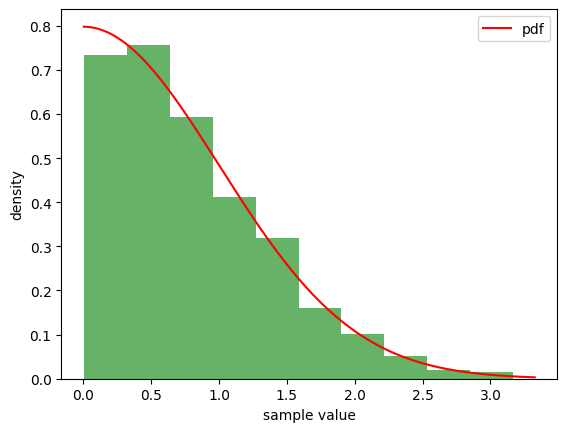

Half-normal
[Algorithm 1] ECDF optimized parameters: [ 0.15250836  0.12226054  5.56403495  0.00862427  0.34987187 -0.0096285 ]
[Algorithm 2] MLE Optimized Parameters: [0.72423324 0.18503016 1.7899773  0.55735241 1.92986948 0.18253041]
AIC:  2412.0998030826468 AICc: 1501.4785873305455 BIC:  2441.5463347565396 EDC: 2388.5039346791505 Log-Likelihood -1200.0499015413234
KS : KstestResult(statistic=0.3066215136790619, pvalue=5.876563268140816e-84, statistic_location=0.6531980437977383, statistic_sign=-1)
AIC:  1463.8619130040884 AICc: 553.240697251987 BIC:  1493.3084446779812 EDC: 1440.266044600592 Log-Likelihood -725.9309565020442
KS : KstestResult(statistic=0.01594806317595661, pvalue=0.957566995596841, statistic_location=0.12956613871373937, statistic_sign=1)
[0.72423324 0.18503016 1.7899773  0.55735241 1.92986948 0.18253041] 1463.8619130040884 553.240697251987 1493.3084446779812 1440.266044600592 -725.9309565020442


In [14]:
from scipy.stats import halfnorm

sample = halfnorm.rvs(size=1000, loc=0.001)

fig, ax = plt.subplots(1, 1)

plt.hist(sample, bins=10, density=True, alpha=0.6, color='g')

x = np.linspace(0.95*min(sample), 1.05*max(sample), 1000)
pdf_values = halfnorm.pdf(x)

plt.plot(x, pdf_values, 'r-', label='pdf')
plt.xlabel('sample value')
plt.ylabel('density')
plt.legend()
plt.show()

optimal_params_llf, aic, aicc, bic, edc, logLik = estimate_extremeH(sample)

print(optimal_params_llf, aic, aicc, bic, edc, logLik)